In [1]:
import pandas as pd
import os,sys, imp
sys.path.append('./src/')
import doc_utils_clean as doc_utils
import feature_utils
import defines
import numpy as np
from sklearn_crfsuite import scorers, CRF
from sklearn_crfsuite import metrics
from sklearn_crfsuite.metrics import flat_classification_report
from sklearn.model_selection import LeaveOneGroupOut,LeavePGroupsOut,GroupKFold

from operator import itemgetter
from sklearn_crfsuite.utils import flatten
from sklearn.metrics import confusion_matrix, plot_confusion_matrix
import random
import model_utils
import seaborn as sns
import matplotlib.pyplot as plt
import sklearn


In [2]:
print('The scikit-learn version is {}.'.format(sklearn.__version__))

The scikit-learn version is 1.1.1.


In [3]:
dir_name="merged_sent"
info_file_name="1_pred_info.csv"

In [4]:
db_path = os.path.join(os.getcwd(),defines.PATH_TO_DFS,dir_name)

In [5]:
imp.reload(doc_utils)
doc_db =  pd.read_csv("./dataframes/doc_db.csv")
doc_db.sort_values(by='doc_idx_from_name',inplace=True)
doc_db

,path,file_name,doc_idx_from_name,par_count,sent_count,nar_sent_count
0,/scratch/sim_reg6/users/zsofya/classroom/MSc/p...,01_aingimel3_lc.docx,1,205.000000,580.000000,256.000000
1,/scratch/sim_reg6/users/zsofya/classroom/MSc/p...,02_aingimel12_lc.docx,2,157.000000,632.000000,70.000000
2,/scratch/sim_reg6/users/zsofya/classroom/MSc/p...,03_aingimel26_lc.docx,3,118.000000,559.000000,102.000000
3,/scratch/sim_reg6/users/zsofya/classroom/MSc/p...,04_nun2_lc.docx,4,132.000000,460.000000,172.000000
4,/scratch/sim_reg6/users/zsofya/classroom/MSc/p...,05_kafhey_23_lc.docx,5,65.000000,510.000000,270.000000
...,...,...,...,...,...,...
75,/scratch/sim_reg6/users/zsofya/classroom/MSc/p...,76_nun2_Mor.docx,76,132.000000,464.000000,164.000000
76,/scratch/sim_reg6/users/zsofya/classroom/MSc/p...,77_nun25_Mor.docx,77,176.000000,406.000000,64.000000
77,/scratch/sim_reg6/users/zsofya/classroom/MSc/p...,78_tsadek27_Mor.docx,78,122.000000,178.000000,44.000000
78,/scratch/sim_reg6/users/zsofya/classroom/MSc/p...,79_tsadek29_Mor.docx,79,173.000000,252.000000,70.000000


### Error analysis

In [6]:
pred_info_df = pd.read_csv(os.path.join(os.getcwd(),defines.PATH_TO_DFS,dir_name,info_file_name))

In [7]:
y_test = pred_info_df['label'].tolist()
y_pred = pred_info_df['pred'].tolist()
y_pred_proba =  pred_info_df['pred_proba'].tolist()
labels = pred_info_df['label'].unique()

              precision    recall  f1-score   support

     not_nar       0.85      0.90      0.87      5227
      is_nar       0.70      0.61      0.65      2089

    accuracy                           0.81      7316
   macro avg       0.78      0.75      0.76      7316
weighted avg       0.81      0.81      0.81      7316



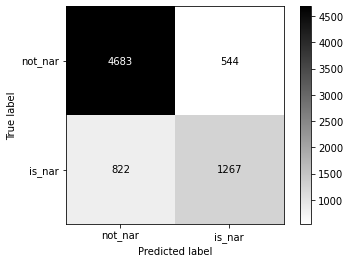

In [8]:
imp.reload(feature_utils)
feature_utils.get_prediction_report(y_test,y_pred,labels)

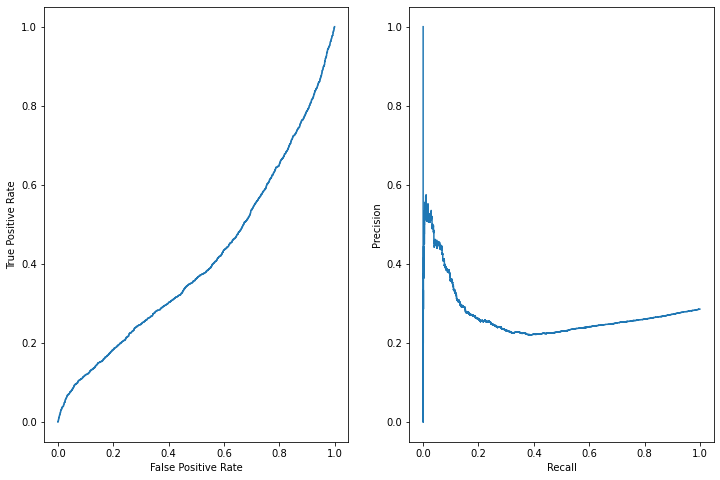

In [22]:
from sklearn.metrics import PrecisionRecallDisplay
from sklearn.metrics import RocCurveDisplay
from sklearn.metrics import precision_recall_curve
from sklearn.metrics import roc_curve


fpr, tpr, _ = roc_curve(y_test, y_pred_proba, pos_label='is_nar')
roc_display = RocCurveDisplay(fpr=fpr, tpr=tpr)

prec, recall, _ = precision_recall_curve(y_test, y_pred_proba,  pos_label='is_nar')
pr_display = PrecisionRecallDisplay(precision=prec, recall=recall)

fig, (ax1, ax2) = plt.subplots(1, 2, figsize=(12, 8))

roc_display.plot(ax=ax1)
pr_display.plot(ax=ax2)
plt.show()

### Check distribution of confidence for wrong/correct predictions

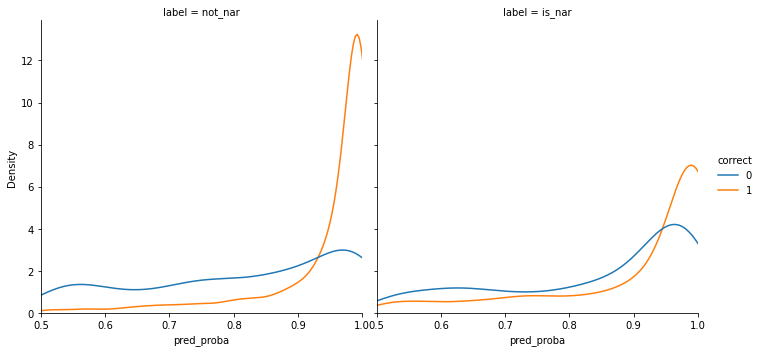

In [34]:
dens = sns.displot(data=pred_info_df,x='pred_proba',hue='correct',col='label',common_norm=False,kind='kde')
dens.set(xlim=(0.5,1))

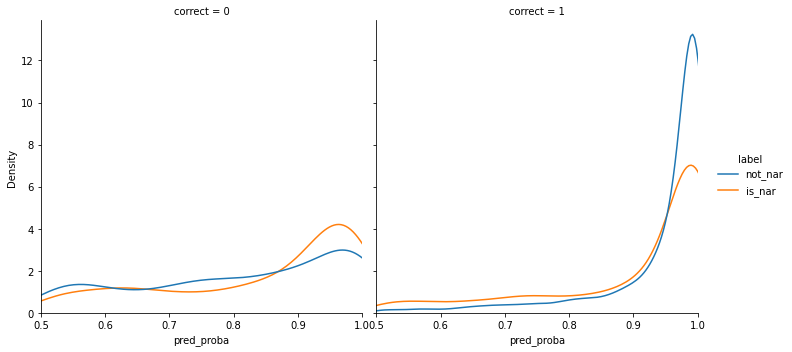

In [35]:
dens = sns.displot(data=pred_info_df,x='pred_proba',hue='label',col='correct',common_norm=False,kind='kde')
dens.set(xlim=(0.5,1))

In [40]:
conf_threshold = 0.9
strong_err_idx = pred_info_df.query('correct == 0 and pred_proba > @conf_threshold').index
strong_err_idx

Int64Index([  16,   25,   26,   27,   28,   29,   64,   65,   66,   67,
            ...
            6955, 6956, 6957, 6958, 6975, 6976, 6987, 7249, 7291, 7292],
           dtype='int64', length=642)

In [180]:
imp.reload(model_utils)
model_utils.print_error_par_text(strong_err_idx,pred_info_df)

In [127]:
pred_info_df.iloc[0]

seq_idx                               0.000000
idx_in_seq                            0.000000
doc_idx                              32.000000
seq_len                              25.000000
label                                  not_nar
pred                                   not_nar
pred_proba                            0.578161
correct                                      1
is_nar                                0.000000
is_client                             1.000000
sent_len                             27.000000
par_idx_in_doc                        0.000000
sent_idx_in_par                       0.000000
is_question                           0.000000
text               שאלת אותי ככה בפגישה הקודמת
TOKEN                                 5.000000
Name: 0, dtype: object

In [29]:
strong_err_par.sort_values(by='pred_proba',ascending=False,inplace=True)
strong_err_par

,doc_idx,par_idx_in_doc,pred_proba
189,29.000000,95.000000,0.999804
43,12.000000,58.000000,0.999666
46,12.000000,64.000000,0.999531
191,29.000000,97.000000,0.999503
96,18.000000,9.000000,0.998997
...,...,...,...
480,79.000000,44.000000,0.906125
334,70.000000,66.000000,0.904850
107,18.000000,25.000000,0.903994
425,72.000000,310.000000,0.902273


In [30]:
from termcolor import colored, cprint

In [103]:
color_map = {
    1: 'green',
    0: 'red'
}
nar_args = {
    1: ['underline']
}
on_color = {
    'label': 'on_yellow',
    'pred': 'on_cyan'
}

def get_error_par_text(_strong_err_par,pred_info_df):
    strong_err_par = _strong_err_par.copy()
    strong_err_par.sort_values(by=['doc_idx','par_idx_in_doc'],inplace=True)
    for idx,row in strong_err_par.iterrows():
        sentenses = {}
        pred = {}
        label = {}
        par_sent_db = {}
        par_idx = {}
        is_nar = {}
        doc_idx = row['doc_idx']
        par_idx[0] = row['par_idx_in_doc']
        par_sent_db[0] = pred_info_df.query("doc_idx == @doc_idx and par_idx_in_doc== @par_idx[0]")
#         if len(par_sent_db[0].index) < 2: 
#             for neighbor in [-1,1]:
#                     par_idx[neighbor] = par_idx[0]+neighbor
#                     par_sent_db[neighbor] = pred_info_df.query("doc_idx == @doc_idx and par_idx_in_doc== @par_idx[@neighbor]")
        print("==========\n{} doc".format(doc_idx))
        for key in sorted(par_sent_db):
            sentenses[key] = par_sent_db[key]['text'].tolist()
            pred[key]  = par_sent_db[key]['pred'].tolist()
            label[key] = par_sent_db[key]['label'].tolist()
            is_nar[key] = par_sent_db[key]['is_nar'].tolist()
            print("{} par[{}]: confidence {:03f}".format(par_idx[key],key,row['pred_proba']))
            cprint("Correct labeling:",attrs=['bold'])
            for i,sent in enumerate(sentenses[key]):
                cprint(text="{}".format(sentenses[key][i]), on_color=on_color['label'] if label[key][i]=='is_nar'else None,end='.')
            cprint("\nPredicted labeling:",attrs=['bold'])
            for i,sent in enumerate(sentenses[key]):
                cprint(text="{}".format(sentenses[key][i]), on_color=on_color['pred'] if pred[key][i]=='is_nar'else None,end='.')
            print("\n")


        
get_error_par_text(strong_err_par,pred_info_df)

4.0 doc
6.0 par[0]: confidence 0.998452
Correct labeling:
שאתה אחד מהם.
Predicted labeling:
שאתה אחד מהם.

5.0 doc
32.0 par[0]: confidence 0.988809
Correct labeling:
 אני חושבת שה הדבר המתאגר מסיטואציות XXX זה גם לקבל את זה שלפעמים XXX לא.לא מסתדרים לא מצליחים גם התהליכים שאנחנו עושים כמטפלים לפעמים לא מצליחים.יש מטופלים שזה XXX איתם ויש מטופלים שזה לא עובד איתם.זה גם חלק מהעניין.אבל מעבר לזה אני חושבת שבאמת המקום שבו.זה המקום שדיברת עליו בהרבה סיטואציות אחרות שהפעיל והגיע למקום קשים המקום של הזמנים או.משהו אחר או דברים אחרים שכאילו משהו בדבר הזה נחווה כאיזה פגיעה. ממה זה?.מה הייתה מבחינתך התקשורת XXX?.
Predicted labeling:
 אני חושבת שה הדבר המתאגר מסיטואציות XXX זה גם לקבל את זה שלפעמים XXX לא.לא מסתדרים לא מצליחים גם התהליכים שאנחנו עושים כמטפלים לפעמים לא מצליחים.יש מטופלים שזה XXX איתם ויש מטופלים שזה לא עובד איתם.זה גם חלק מהעניין.אבל מעבר לזה אני חושבת שבאמת המקום שבו.זה המקום שדיברת עליו בהרבה סיטואציות אחרות שהפעיל והגיע למקום קשים המקום של הזמנים או.משהו אחר או דברים אחרים שכא

12.0 doc
101.0 par[0]: confidence 0.987205
Correct labeling:
כן עשיתי טעות עברתי ו.
Predicted labeling:
כן עשיתי טעות עברתי ו.

12.0 doc
102.0 par[0]: confidence 0.984512
Correct labeling:
ואז מה?.
Predicted labeling:
ואז מה?.

14.0 doc
12.0 par[0]: confidence 0.939497
Correct labeling:
רגע באיזה בנק אתה?.
Predicted labeling:
רגע באיזה בנק אתה?.

14.0 doc
13.0 par[0]: confidence 0.947411
Correct labeling:
אני בנק לאומי אבל בנק לאומי רוב הסניפים סגרו את הקופות אז הלכתי היום לבנק טפחות.פעם שעברה הלכתי לבנק דיסקונט.כאילו אני עובר בין סניפים.
Predicted labeling:
אני בנק לאומי אבל בנק לאומי רוב הסניפים סגרו את הקופות אז הלכתי היום לבנק טפחות.פעם שעברה הלכתי לבנק דיסקונט.כאילו אני עובר בין סניפים.

14.0 doc
14.0 par[0]: confidence 0.958207
Correct labeling:
לא אני אני חושב שמה שהוא התכוון להגיד לך שאם אתה בבנק מזרחי כי האוניברסיטה היא בבנק מזרחי אולי הוא חשב.שאתה בבנק מזרחי.
Predicted labeling:
לא אני אני חושב שמה שהוא התכוון להגיד לך שאם אתה בבנק מזרחי כי האוניברסיטה היא בבנק מזרחי אולי הוא

18.0 doc
13.0 par[0]: confidence 0.936581
Correct labeling:
 יש הרבה תסכול ולחץ וחוסר יכולת לתקשר זאת אומרת כאילו זה כאילו מחדד פערים ואשתי דיי אמרה שיש לא מעט  אני בדרך כלל תמיד יודע מה אני לא רוצה ולא מה אני כן רוצה אה ובסופו של כאילו זה לא שאני יודע אני רוצה לעשות א ב או ג אבל לפחות מבחינת הדרך לאן אני רוצה להגיע או מאיזה אממ  מטענים אני רוצה להשתחרר  אז בתוך זה היא כאילו  זה יוצר מצב ש בתפיסה מבחינתה XXX XXX כאילו אני תאורטיקן או אידיאליסט מדיי והחיים הם כאילו מאוד אה מאוד פרקטים אז אני בן אדם מורכב בין אם אני רוצה ובין אם לא ואני צריך איכשהו לגשר על הפער של המורכבות הזה ואני מרגיש שאני עושה ודיברנו על זה לא מעט כאילו מסכות או  אה התאמות שאני נדרש לעשות ביחס למהות הפנימית שלי שאני עדיין לא מבין ומכיר אותה אבל לפחות שהיא באיזשהו אופן נחשפת ומצד שני היא כאילו מאוד תכליתית היא לקחה את זה למקום מאוד קיצוני כאילו עם הרבה חוסר סבלנות גם אני עם עצמי במובן מהיבטים אחרים אז המון חוסר סבלנות הרבה ביקורתיות כאילו סתם דוגמה.דיברתי איתך על העניין הזה של החברה הזאת שמייצגת וכו היו לי לבטים מאוד 

28.0 doc
29.0 par[0]: confidence 0.937219
Correct labeling:
כאילו אולי אחד הדברים שאני מנסה לעבוד עליהם זה לדבר קצר וענייני ולהעביר משהו כמסר מרכזי ואני לא עושה את זה.
Predicted labeling:
כאילו אולי אחד הדברים שאני מנסה לעבוד עליהם זה לדבר קצר וענייני ולהעביר משהו כמסר מרכזי ואני לא עושה את זה.

28.0 doc
30.0 par[0]: confidence 0.923813
Correct labeling:
 מה המסר המרכזי של הסיפור עם יל?.
Predicted labeling:
 מה המסר המרכזי של הסיפור עם יל?.

28.0 doc
33.0 par[0]: confidence 0.996393
Correct labeling:
אני חושבת שמה שעמד זה שהיא תרגיש לא תרגיש נוח.
Predicted labeling:
אני חושבת שמה שעמד זה שהיא תרגיש לא תרגיש נוח.

28.0 doc
34.0 par[0]: confidence 0.993621
Correct labeling:
 ממה היא חששה לדעתך?.
Predicted labeling:
 ממה היא חששה לדעתך?.

28.0 doc
36.0 par[0]: confidence 0.996644
Correct labeling:
 אתה חושב שיש משהו בקשר שלכם שהוביל אותה להיות זהירה עם ההכנסה שלך לקבוצה?.
Predicted labeling:
 אתה חושב שיש משהו בקשר שלכם שהוביל אותה להיות זהירה עם ההכנסה שלך לקבוצה?.

28.0 doc
37.0 par[0]:

29.0 doc
88.0 par[0]: confidence 0.928544
Correct labeling:
אני פעם אחת אמרתי לאמא שלי את זוכרת את המכות שהייתם מרביצים לי?.שאת הייתוהיא התחילה לקבל ויברציה בגוף והיא לא זוכרת כלום מזה .אבל הגוף לא משקר.זה מה שאני אומר הגוף לא משקר לא יעזור.כי אם היית נינוחה עם זה אם היא הייתה נינוחה אז היא לא הייתה מקבלת כאלה את רואה שלא נוח לך בגוף מקבלת ויברציות כאלה.
Predicted labeling:
אני פעם אחת אמרתי לאמא שלי את זוכרת את המכות שהייתם מרביצים לי?.שאת הייתוהיא התחילה לקבל ויברציה בגוף והיא לא זוכרת כלום מזה .אבל הגוף לא משקר.זה מה שאני אומר הגוף לא משקר לא יעזור.כי אם היית נינוחה עם זה אם היא הייתה נינוחה אז היא לא הייתה מקבלת כאלה את רואה שלא נוח לך בגוף מקבלת ויברציות כאלה.

29.0 doc
94.0 par[0]: confidence 0.992637
Correct labeling:
בפועל המשרה זה בדיוק מה ששאלתי אותה מה זה אומר איך נראה היום שלי ממ בלי כל ההבטחות מה זה אומר במציאות?.מגיע יום עבודה היא רוצה שאני אעשה לה את ההרשמות שזה אומר תכלס לעשות טלמרקטינג להתקשר ללידים ולרשום אותם.אני עושה את זה עכשיו כבר כמה שבועות.עכשיו זה אחלה כסף וזה 

32.0 doc
36.0 par[0]: confidence 0.943338
Correct labeling:
אין אין לזה מספרים אבל אני יודעת שנגיד סתם דוגמה רוב הנשים בגילי לא מתלבשות כמוני למרות שאת הבגדים שלי אני קונה בחנויות אני לא תופרת אותם בעצמי הם קיימים שם אני לא ממציאה אותם לא מתלבשות לא נראות כמוני אני לא יודעת אם להגיד לך אם הרוב אבל הרבה נגיד מתאפרות אני רואה הרבה אנשים בעבודה שלי והם אם נרשמים אז אני גם יודעת את הגיל שלהם ויש כאלה לפעמים כאילו בעיקר אנשים XXX מה זאת בגילי?.נראית הרבה יותר מבוגרת כאילו בעיניים שלי יכול להיות שאני בעיניים של מישהי אחרת גם נראית מבוגרת אני לא יודעת אני יודעת שעד גיל 36 עד שחליתי תמיד נראיתי צעירה מגילי מה שקיבלתי פידבק מהסביבה וגם הרגשתי ואז פתאום כזה התחלתי להזדקן עכשיו גם היום אני אני לא יודעת להגיד לך אם אני מרגישה בגילי אבל מרגישה יותר מבוגרת וכשאני מסתכלת על נשים אחרות בגילי אז חלקן נראות לי יותר נראות פחות טוב ממני לא יודעת חלקן גם יותר זה גם XXX כן אבל יש לפעמים יש את הקטע הזה ש יש דבר אחד שאסור לקנות תרופות מתחת לגיל 16 אז אם בא מולי בחורה צעירה בחור צעיר ונראים לי צעירים מדי אני צ

65.0 doc
18.0 par[0]: confidence 0.998447
Correct labeling:
כן?.
Predicted labeling:
כן?.

65.0 doc
19.0 par[0]: confidence 0.997972
Correct labeling:
כן ש אני לא אגלוש כאילו.אני לא אעשה את זה.אני לא שהדבר הזה שעצם הדבר הזה לא יגלוש.זאת אומרת שאני לא אבוא לאנשים.אני גם לא עשיתי את זה.אני לא אבוא לאנשים במכון ואני אעביר אותם כאילו.אליי כלקוחות זה אני בהחלט מסכים.אבל אם אנשים פונים אליי והם רואים.הם רואים פרסום שלי בפייסבוק  הם רוצים כאילו את האוויר.
Predicted labeling:
כן ש אני לא אגלוש כאילו.אני לא אעשה את זה.אני לא שהדבר הזה שעצם הדבר הזה לא יגלוש.זאת אומרת שאני לא אבוא לאנשים.אני גם לא עשיתי את זה.אני לא אבוא לאנשים במכון ואני אעביר אותם כאילו.אליי כלקוחות זה אני בהחלט מסכים.אבל אם אנשים פונים אליי והם רואים.הם רואים פרסום שלי בפייסבוק  הם רוצים כאילו את האוויר.

65.0 doc
20.0 par[0]: confidence 0.995327
Correct labeling:
כן אתה גם צריך לדאוג לעצמך.אתה באמת.
Predicted labeling:
כן אתה גם צריך לדאוג לעצמך.אתה באמת.

65.0 doc
21.0 par[0]: confidence 0.916709
Correct labeling:
ברור  זה 

70.0 doc
148.0 par[0]: confidence 0.932911
Correct labeling:
אה  אושר חיבוק אה  אה  אה זאת אומרת אה אני חושב שאני מסתכל יכול להיות שלפעמים אני גם מסתכל על קשר אחד שהיה לי בעבר שהייתה לי שאני אה.כמה חודשים אישה אחת XXX שהיינו XXX הייתה ההיילייט של הערב שהיא קצת XXX לפני גן לא חשוב גם גן היה כיפי מאוד היה היה גיל אחר תקופה אחרת.
Predicted labeling:
אה  אושר חיבוק אה  אה  אה זאת אומרת אה אני חושב שאני מסתכל יכול להיות שלפעמים אני גם מסתכל על קשר אחד שהיה לי בעבר שהייתה לי שאני אה.כמה חודשים אישה אחת XXX שהיינו XXX הייתה ההיילייט של הערב שהיא קצת XXX לפני גן לא חשוב גם גן היה כיפי מאוד היה היה גיל אחר תקופה אחרת.

72.0 doc
11.0 par[0]: confidence 0.934790
Correct labeling:
אני לא זוכר מתי זה קרה.כאילו את יודעת אני מעביר חוגים אני מעביר זה.ובאמת ב אני מוציא מעצמי כאילו מלא.תעצומות של זה לא אנרגיה זה כאילו כוח רצון כדי להעביר את זה.
Predicted labeling:
אני לא זוכר מתי זה קרה.כאילו את יודעת אני מעביר חוגים אני מעביר זה.ובאמת ב אני מוציא מעצמי כאילו מלא.תעצומות של זה לא אנרגיה זה כאילו כוח רצו

72.0 doc
313.0 par[0]: confidence 0.969420
Correct labeling:
של העסק הוא צמח הוא צמח יפה.זאת אומרת  הוא עכשיו בדעיכה קלה כזאתי.בדעיכה לא קלה.דעיכה.
Predicted labeling:
של העסק הוא צמח הוא צמח יפה.זאת אומרת  הוא עכשיו בדעיכה קלה כזאתי.בדעיכה לא קלה.דעיכה.

72.0 doc
314.0 par[0]: confidence 0.948461
Correct labeling:
כן אם היית רוצה היית מרים אותו.
Predicted labeling:
כן אם היית רוצה היית מרים אותו.

72.0 doc
315.0 par[0]: confidence 0.986756
Correct labeling:
כן אם הייתי מספיק רוצה אז בהחלט.בשבועיים האחרונים עם כל המצעד וזה והכדורים האלה שעייפו אותי וזה.אז יש את ה.
Predicted labeling:
כן אם הייתי מספיק רוצה אז בהחלט.בשבועיים האחרונים עם כל המצעד וזה והכדורים האלה שעייפו אותי וזה.אז יש את ה.

72.0 doc
317.0 par[0]: confidence 0.996990
Correct labeling:
מצד שני אני גם בסדר עם זה.
Predicted labeling:
מצד שני אני גם בסדר עם זה.

72.0 doc
321.0 par[0]: confidence 0.989896
Correct labeling:
יב נגיד נעלם מהחיים.
Predicted labeling:
יב נגיד נעלם מהחיים.

72.0 doc
326.0 par[0]: confidence 0.9967

In [67]:
check_doc =[(12,97),(14,47),(15,93),(18,15),(79,5)]
looks_like_nar=[(28,55),(32,20),(55,30),(55,136)]

In [108]:
for i in check_doc[1:2]:
    print(i)
    doc_db = pred_info_df.query("doc_idx == @i[0] and par_idx_in_doc == @i[1]")
    print(doc_db['text'].tolist())
    break

(14, 47)
['אני לא יודע מה השתנה', 'אני חושב שזה גם סוג של מה שקורה בלימודים', 'שאם פעם הייתה לי את המוטיבציה הזאת אז היום גם אין לי את המוטיבציה הזאת', 'אני לא יודע איך יש קשר בין הדברים אני רק יודע שזה בא ביחד', 'כי כשירד שם גם ירד שם', 'כאילו ה הרצון ונגיד עכשיו שהייתי צריך לשלם את החודש הזה', 'אז אמרתי לעצמי', 'כאילו אתמול או שלשום אמרתי לעצמי', 'טוב אני אלך מתי שהוא לבנק', 'ו אתמול אמרתי את זה', 'אמרתי אני אלך מתי שהוא לבנק', 'והיום בדרך בנסיעה', 'אמרתי לא זה לא אפשרי אני לא יכול כל דבר ככה לדחות', 'ונסעתי לבנק שזה לא באמת סיפור זה 2 דקות', 'אבל זה כאילו משהו נכנס למחשבה שכל משימה זה כזה', 'טוב אני אעשה את זה מתי שהוא', 'לדחות דברים נותנים לי איזה טלפון שאני צריך להתקשר לבן אדם לדבר איתו אני אעשה את זה מתי שהוא', 'הכל לדחות דברים לדחות וזה לא פיתרון כי מתי שהוא צריך לעשות את זה', 'אי אפשר לדחות את זה', 'זה בא ביחד', 'זה כאילו זה דברים שאני שם לב תוך כדי', 'כמו ששמתי לב נגיד ש', 'יש בווטסאפ הכניסו את הפיצר הזה בשנה או בשנתיים האחרונות שאפשר לראות מי נראה לאחרונה או מי קרא את ההודעה'

In [110]:
err_docs = err_pred_info['doc_idx'].unique()
for doc_idx in err_docs[:1]:
    sent_db = pd.read_csv(os.path.join(db_path,"{:02d}_sent_db.csv".format(int(doc_idx))))
    doc_samples = err_pred_info.query("doc_idx == @doc_idx")
    err_par_of_doc = doc_samples['par_idx_in_doc'].unique()
    for par_idx in err_par_of_doc:
        par_samples = doc_samples.query("par_idx_in_doc == @par_idx")
        for par in par_samples.index:
#             sent
            display (sent_db.loc[par_samples])
    

# for i,idx in enumerate(list(err_pred_info.index)[:3]):
#     doc_idx = int(err_pred_info.loc[idx,'doc_idx'])
#     par_idx = int(err_pred_info.loc[idx,'par_idx_in_doc'])
#     sent_db = pd.read_csv(os.path.join(db_path,"{:02d}_sent_db.csv".format(doc_idx)))
#     err_par = sent_db.query("par_idx_in_doc == @par_idx")['text']
#     display(err_par)
#     print("{}: {}".format(i,err_par))

ValueError: Cannot index with multidimensional key

In [91]:
from termcolor import colored
print(colored('hello', 'red'), colored('world', 'green'))
print(colored("hello red world", 'red'))

hello world
hello red world


## Merge error and correct sentenses into single df

In [102]:
compare_df = pd.concat([err_pred_info,corr_pred_info],keys=['error','correct'])
compare_df.reset_index(inplace=True)
compare_df.rename(columns={'level_0':'prediction'},inplace=True)
compare_df

,prediction,level_1,seq_idx,idx_in_seq,doc_idx,seq_len,label,pred,pred_proba,is_nar,is_client,sent_len,par_idx_in_doc,sent_idx_in_par,is_question,text,TOKEN
0,error,0,454.000000,0.000000,12.000000,44.000000,True,False,0.999994,1.000000,0.000000,25.000000,64.000000,0.000000,1.000000,אז לא ברור לימה אתה רוצה?,6.000000
1,error,1,498.000000,72.000000,14.000000,74.000000,False,True,0.999983,0.000000,1.000000,36.000000,47.000000,57.000000,0.000000,אני אם היו אומרים לי הייתי יור במקום,8.000000
2,error,2,498.000000,69.000000,14.000000,74.000000,False,True,0.999919,0.000000,1.000000,42.000000,47.000000,54.000000,0.000000,אחי כזה אח שלי הוא כזה שאומרים לו תרד תביא,10.000000
3,error,3,816.000000,12.000000,29.000000,28.000000,True,False,0.999886,1.000000,0.000000,17.000000,95.000000,0.000000,1.000000,אבל אתה מנהל שם?,4.000000
4,error,4,498.000000,68.000000,14.000000,74.000000,False,True,0.999858,0.000000,1.000000,17.000000,47.000000,53.000000,0.000000,בעבר לא הייתי כזה,4.000000
...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...
5373,correct,4731,157.000000,8.000000,4.000000,16.000000,True,True,0.900568,1.000000,1.000000,15.000000,61.000000,7.000000,0.000000,לפעמים אני עונה,3.000000
5374,correct,4732,742.000000,10.000000,28.000000,20.000000,False,False,0.900560,0.000000,0.000000,40.000000,40.000000,5.000000,0.000000,over לדאוג לך over לא ליפול שם באיזה פח,8.000000
5375,correct,4733,2.000000,21.000000,32.000000,24.000000,True,True,0.900316,1.000000,1.000000,132.000000,8.000000,1.000000,0.000000,נגיד אני מסתכלת על הנייר אז איזה ימים יש לי או...,26.000000
5376,correct,4734,196.000000,2.000000,36.000000,4.000000,False,False,0.900218,0.000000,1.000000,305.000000,47.000000,0.000000,0.000000,טוב אז גדלתי עם בית שאבא שלי הוא היה מאוד דו...,38.000000


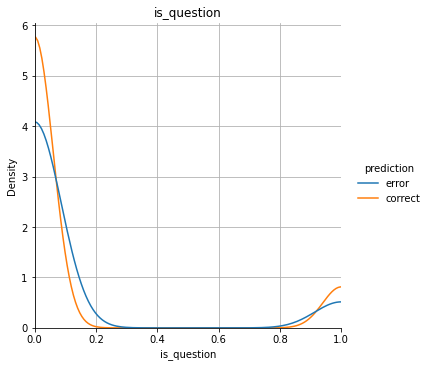

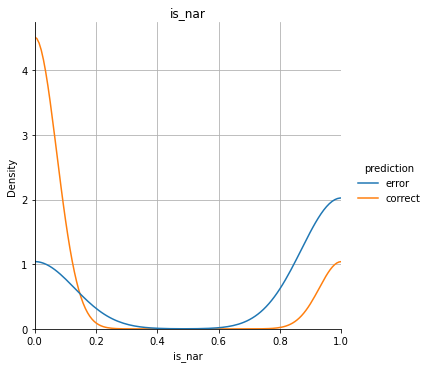

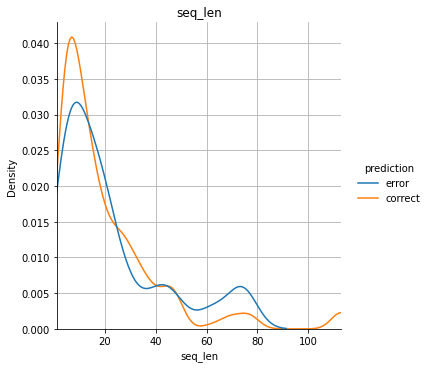

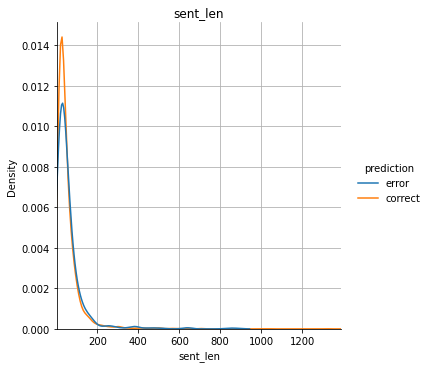

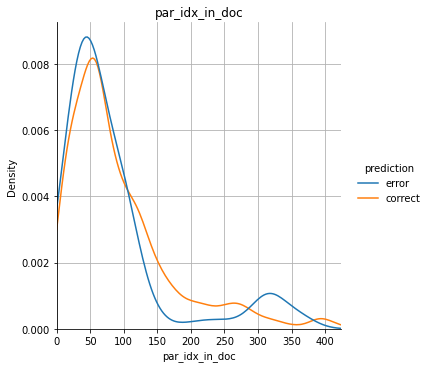

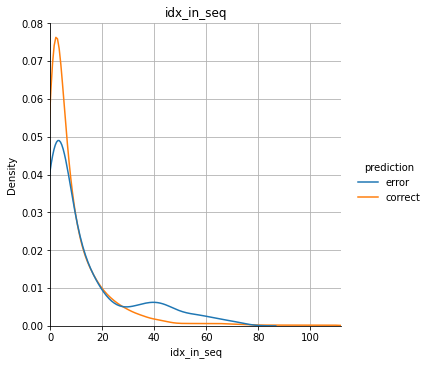

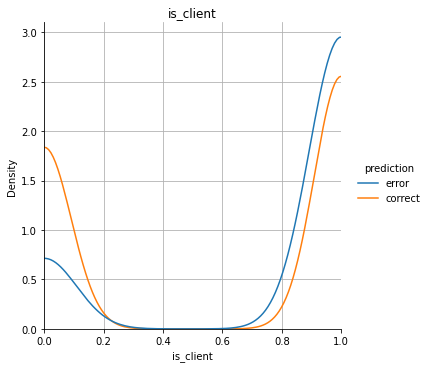

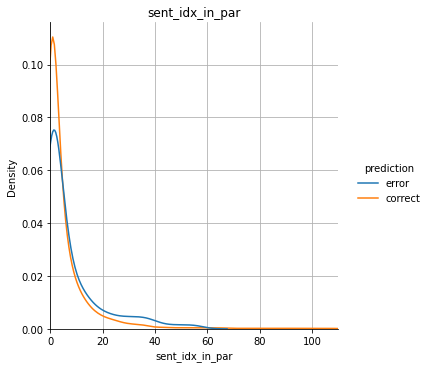

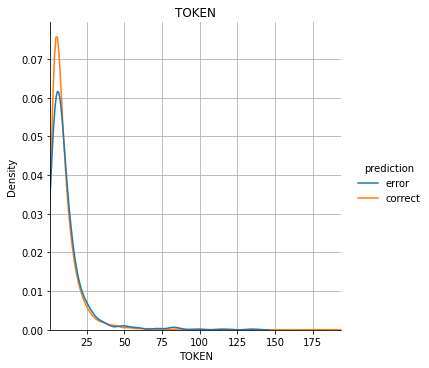

In [104]:
all_columns = set(compare_df.columns)
exclude_columns  = set(['label','pred','prediction','level_1','seq_idx','doc_idx','pred_proba','text'])
include_columns = all_columns-exclude_columns

for i,col in enumerate(include_columns):
    plot =  sns.displot(data=compare_df,
                        x=col,
                       hue = 'prediction',
                        common_norm=False,
                         kind='kde'
                       )
    plot.set(xlim=(compare_df[col].min(),compare_df[col].max()),title=col)
    plt.grid()

## View error pattern in sequences

### Detect samples with high error ratio per sequence

In [ ]:
def f(group):
    return pd.DataFrame({'seq_idx': group['seq_idx'],
                         'idx_in_seq': group['idx_in_seq'],
                         'err_ratio': len(group)/group['seq_len']})

grouped=err_pred_info.groupby('seq_idx')
seq_err_ratio = grouped.apply(f)
uniq = seq_err_ratio.drop_duplicates(subset='seq_idx', inplace=False, ignore_index=True)
uniq_sorted = uniq.sort_values(by='err_ratio',ascending=False)
uniq_sorted['err_ratio'].hist()

In [ ]:
seq_err_ratio

In [ ]:
entire_seq_err = uniq_sorted.query('err_ratio == 1')['seq_idx'].tolist()

In [ ]:
err_pred_info.query("seq_idx in @entire_seq_err").sort_values(by=['seq_idx','idx_in_seq'])

## TODO:
1. find what patterns are popular [false-false-true...]
2. try to catch differences between correct & error pattern

In [ ]:
def calc_err_ratio(grp):
#     print("grp size {} seq len {}".format(grp.size,set(grp['seq_len'])))
    grp['err_ratio'] = len(grp)/grp['seq_len']
    return grp
 
new_df=err_pred_info.groupby('seq_idx').apply(lambda x: len(x)/x['seq_len'])
new_df
# err_pred_info.groupby("seq_idx").transform(calc_err_ratio)

In [ ]:
err_pred_info

In [ ]:
error_features_df = pd.DataFrame()
keys = ['sent_len','is_client','sent_idx_in_par','par_idx_in_doc','TOKEN']
def add_sent_info(_pred_df):
    pred_df = _pred_df.copy()
    for idx,row in _pred_df.iterrows():
        err_sent = X_test[int(row['seq_idx'])][int(row['idx_in_seq'])]
        for key in keys:
            pred_df.loc[idx,key] =  err_sent[key]
    return pred_df

info_strong_err = add_sent_info(strong_err)
info_strong_err

In [ ]:
info_strong_corr = add_sent_info(strong_corr)
info_strong_corr

In [ ]:
compare_df = pd.concat([info_strong_err,info_strong_corr],keys=['error','correct'])
compare_df.reset_index(inplace=True)
compare_df.rename(columns={'level_0':'prediction'},inplace=True)
compare_df

In [ ]:
all_columns = set(compare_df.columns)
exclude_columns  = set(['label','pred','prediction','level_1'])
include_columns = all_columns-exclude_columns

for i,col in enumerate(include_columns):
    plot =  sns.displot(data=compare_df,
                        x=col,
                       hue = 'prediction',
                        common_norm=False,
                         kind='kde'
                       )
    plot.set(xlim=(compare_df[col].min(),compare_df[col].max()),title=col)
    plt.grid()

In [ ]:
docs_map_sent = feature_utils.pack_all_doc_sentences_to_map(per_par=False,limit=0,sent_lemma_db_list=[])

In [ ]:
imp.reload(feature_utils)
feature_utils.reshape_docs_map_to_seq(docs_map_sent,per_par=False,seq_len=8,step=8)

In [ ]:
test_percent = 0.25
X_train,y_train,X_test,y_test,test_idx,groups_train,groups_test =  split_test_train_docs(docs_map_sent,test_percent)

In [ ]:
X_test[3]

In [ ]:
crf = CRF(
    min_freq = 5,
    algorithm='lbfgs',
    c1=0.1,
    c2=0.1,
    max_iterations=100,
    all_possible_transitions=True,
    )
crf.fit(X_train, y_train)
y_pred  =  crf.predict(X_test)
labels = list(crf.classes_)
f1 = metrics.flat_f1_score(y_test, y_pred,average='weighted', labels=labels)
recall = metrics.flat_recall_score(y_test, y_pred,average='weighted', labels=labels)
precision = metrics.flat_precision_score(y_test, y_pred,average='weighted', labels=labels)
print ("f1 {}\nrecall {}\nprecition {}".format(f1,recall,precision))

In [ ]:
score =  manual_groups_validate(docs_map_sent,test_percent,num_splits=10)
feature_utils.add_score_to_db(score_db_man,"3_3_man_sent",score)

In [ ]:
score_db_man

In [ ]:
mer_db =   pd.read_csv(r"./dataframes/{:02d}_merged_db.csv".format(int(groups_test[0])))
mer_db.head()

In [ ]:
for i,row in enumerate(X_test):
    for j,item in enumerate(row):
        if not 'is_client' in item:
            print("No client tag in X_test[{}][{}]".format(i,j))


In [ ]:
for index,row in pred_sent_db.iterrows():
    display(row.transpose())
    break


In [ ]:
len(groups_test), len(y_test)

# TODO
[] retrive all strong wrong  / strong correct sentences
[] check the difference

In [ ]:
groups_test[int(err_df.loc[0,'seq_idx'])]

In [ ]:
test_doc_idx = groups_test[int(err_df.loc[0,'seq_idx'])]
print ("Test doc idx = {}".format(test_doc_idx))
sent_db =  pd.read_csv(r"./dataframes/{:02d}_sent_db.csv".format(test_doc_idx))

In [ ]:
sent_db.query("par_idx_in_doc == @error_sent['par_idx_in_doc'] and sent_idx_in_par == @error_sent['sent_idx_in_par']")

In [ ]:
test_idx

In [ ]:
len(y_pred),len(flatten(y_pred))

In [ ]:
len(X_test)

### Cross-validate

In [ ]:
score_db = pd.DataFrame()

In [ ]:
imp.reload(feature_utils)
shapes = [(3,3), # sequence [1:3][4:6]...
          (3,2), # sequence [1:3][3:7]...
          (3,1)] # sequence [1:3][2:4][3:5]...
n_groups = 80 # len(set(groups_plane))
test_percent = 0.40
norm = 1
normed = "norm" if norm else ""
prefix = "no_limit"
n_splits = int(n_groups*test_percent)
n_out = int(n_groups/n_splits)
if n_out == 1:
    logo = LeaveOneGroupOut()
else:
#     logo = LeavePGroupsOut(n_groups=num_out)
    logo = GroupKFold(n_splits=n_splits)
#     print(logo.get_n_splits(X_plane,y_plane,groups_plane))

for shape in shapes[1:2]:
    seq_len = shape[0]
    step = shape[1]
#     X_shaped,y_shaped,groups_shaped = feature_utils.reshape_doc_paragraphs_to_sequence(X_plane,y_plane,groups_plane,seq_len,step)
#     X_shaped,y_shaped,groups_shaped = feature_utils.reshape_docs_map_to_seq(docs_map,seq_len,step)
    score = feature_utils.leave_out_validate(X_shaped,y_shaped,groups_shaped,logo)
    feature_utils.add_score_to_db(score_db,"{}_len{}_step{}_{}".format(prefix,seq_len,step,normed),score)

In [ ]:
score_db

In [ ]:
score_db.to_csv("./dataframes/score_max_len8.csv",index=False)